In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

# Initial Data Manipulation

In [22]:

def add_truck_sequences(file_path):
    df = pd.read_csv(file_path)

    df['inbound_date'] = pd.to_datetime(df['inbound_date'])
    df['planned_arrival_central_time'] = pd.to_datetime(df['planned_arrival_central_time']).dt.time
    df['actual_arrival_central_time'] = pd.to_datetime(df['actual_arrival_central_time']).dt.time

    df['planned_arrival_datetime'] = df.apply(lambda row: pd.Timestamp.combine(row['inbound_date'], row['planned_arrival_central_time']), axis =1)
    df['actual_arrival_datetime'] = df.apply(lambda row: pd.Timestamp.combine(row['inbound_date'], row['actual_arrival_central_time']), axis =1)

    def adjust_date(row, time_column):
        if row[time_column].time() >= pd.Timestamp('12:00').time():
            return row['inbound_date'] + pd.Timedelta(days = 1)
        else:
            return row['inbound_date'] 
    
    df['adjusted_planned_date'] = df.apply(adjust_date, axis = 1, time_column = 'planned_arrival_datetime')
    df['adjusted_actual_date'] = df.apply(adjust_date, axis = 1, time_column = 'actual_arrival_datetime')

    df = df.sort_values(by = ['sortation_center_id', 'adjusted_planned_date', 'planned_arrival_datetime'])
    df['[planned_truck_sequence'] = df.groupby(['sortation_center_id', 'adjusted_planned_date']).cumcount()+1

    df = df.sort_values(by = ['sortation_center_id', 'adjusted_actual_date', 'actual_arrival_datetime'])
    df['actual_truck_sequence'] = df.groupby(['sortation_center_id', 'adjusted_actual_date']).cumcount()+1

    df = df.drop(columns = ['adjusted_planned_date', 'adjusted_actual_date'])

    return df

def filter_time_range(file_path, output_path):
    df = pd.read_csv(file_path)

    df['Prediction_Time'] = pd.to_datetime(df['Prediction_Time'])

    filtered_df = df[(df['Prediction_Time'].dt.time>= pd.Timestamp('12:00').time()) &
                    (df['Prediction_Time'].dt.time < pd.Timestamp('13:00').time())]
    
    filtered_df.to_csv(output_path, index = False)

In [ ]:
file_path = 'linehaul_all.csv'
df_with_sequences = add_truck_sequences(file_path)
df_with_sequences.to_csv('linhaul_all_sequence.csv', index = False)

In [15]:
file_path = 'Raft Predict.csv'
output_path = 'Raft_Predict_filtered.csv'

filter_time_range(file_path, output_path)

In [10]:
import sklearn
print(sklearn.__version__)

1.5.1


# Random Forrest Implementation

n = 5
rand = 10
Package Count Prediction MAE: 1403.3090909090909
Package Count R2: 0.7159773265056214
n = 5
rand = 42
Package Count Prediction MAE: 1433.3151515151515
Package Count R2: 0.6139062714651065
n = 5
rand = 100
Package Count Prediction MAE: 1408.1878787878784
Package Count R2: 0.6953412466173695
n = 5
rand = 200
Package Count Prediction MAE: 1513.5757575757575
Package Count R2: 0.6597292457823206
n = 5
rand = 500
Package Count Prediction MAE: 1427.8727272727274
Package Count R2: 0.7091528441538733
n = 5
rand = 1000
Package Count Prediction MAE: 1435.5757575757577
Package Count R2: 0.7186214865203311
n = 6
rand = 10
Package Count Prediction MAE: 1403.808080808081
Package Count R2: 0.7005993804789445
n = 6
rand = 42
Package Count Prediction MAE: 1276.0505050505053
Package Count R2: 0.6748050697945314
n = 6
rand = 100
Package Count Prediction MAE: 1291.641414141414
Package Count R2: 0.7338846935251511
n = 6
rand = 200
Package Count Prediction MAE: 1586.5656565656564
Package Coun

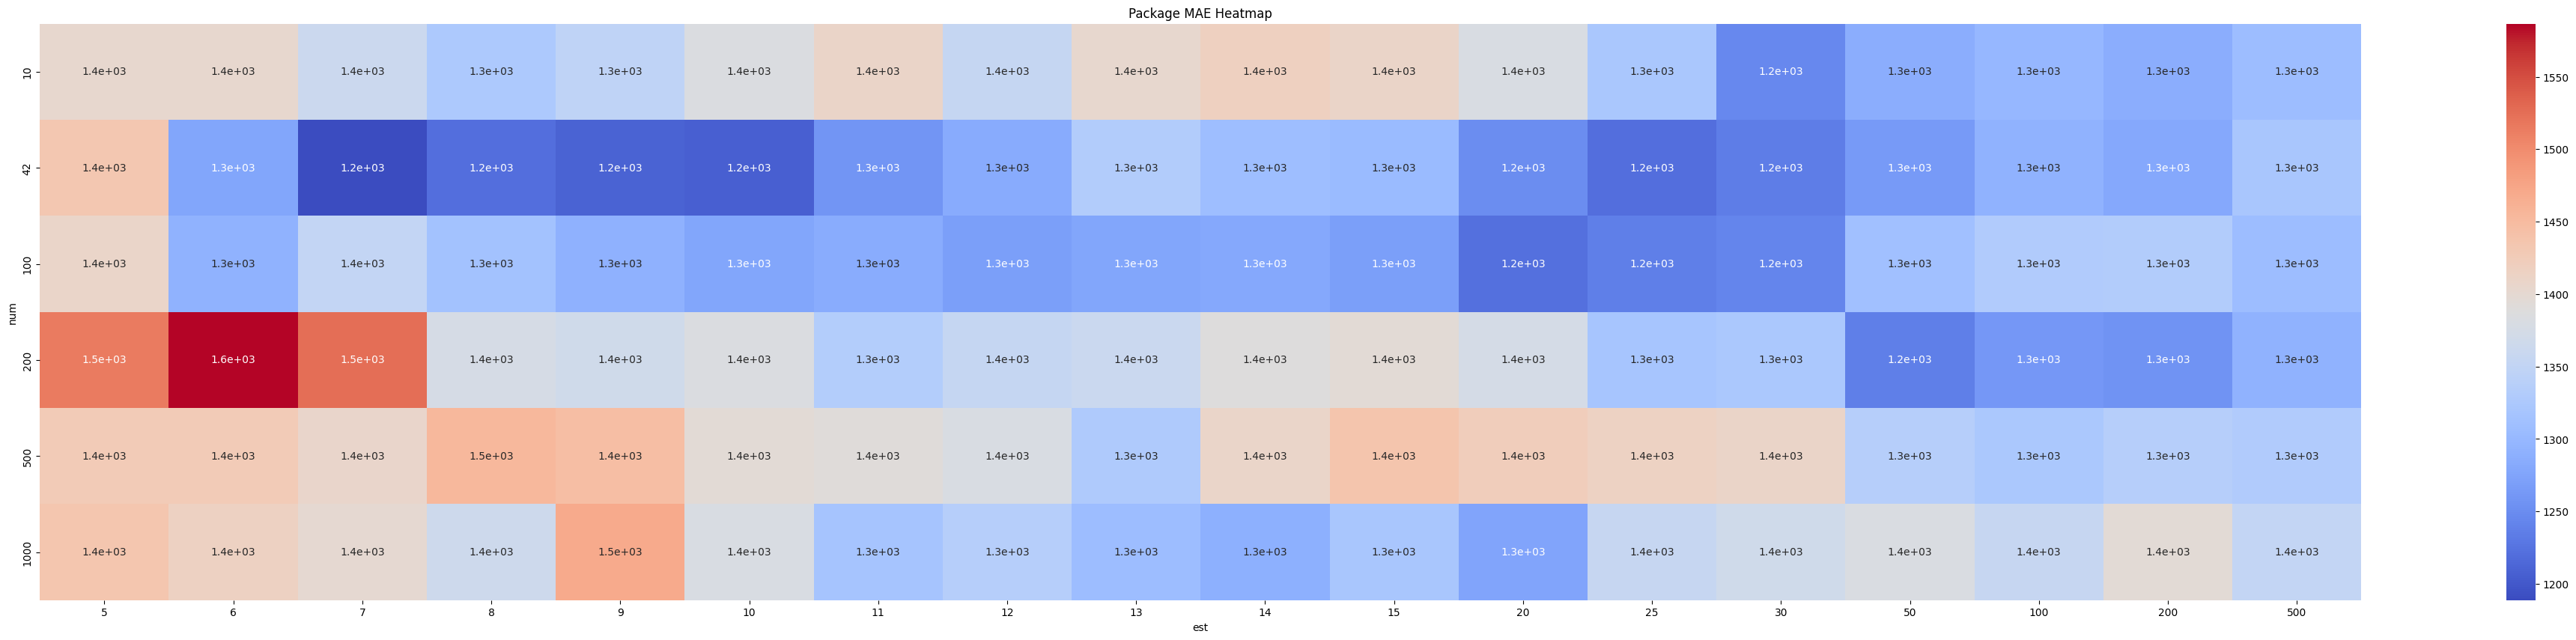

In [53]:

# Load the CSV file into a DataFrame
df = pd.read_csv('Inbound_predict_data.csv')

# one hot encode day of week

df_onehot = pd.get_dummies(df, columns = ['Day of Week'])


# Feature selection
features = ['yesterday_total_packages',
            'RAFT_known_shipped_pkg_count',
            'RAFT_predicted_carryover_pkg_count',
            'RAFT_predicted_total_handoff_pkg_count',
            'Day of Week_Sunday',
            'Day of Week_Monday',
            'Day of Week_Tuesday',
            'Day of Week_Wednesday',
            'Day of Week_Thursday',
            'Day of Week_Friday',
            'Day of Week_Saturday',
            'Promotion',
            'TMAX',
            'TMIN',
            'AWND',
            'PRCP',
            'SNOW']

# Convert date columns to datetime
df_onehot['Prediction_For_Date'] = pd.to_datetime(df['Prediction_For_Date'])

# Extract additional features from date columns
#df['day'] = df['Prediction_For_Date'].dt.day
#df['month'] = df['Prediction_For_Date'].dt.month

# Update features list with new date features
#features.extend(['day', 'month'])

# Split the data into training and testing sets
X = df_onehot[features]
y_package_count = df_onehot['Total Packages Received']
#y_arrival_time = df['actual_arrival_time']

X_train, X_test, y_package_train, y_package_test = train_test_split(X, y_package_count, test_size=0.2, random_state=42)
#X_train, X_test, y_arrival_train, y_arrival_test = train_test_split(X, y_arrival_time, test_size=0.2, random_state=42)

n = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25, 30, 50, 100, 200, 500]
rand = [10, 42, 100, 200, 500,1000]
# loop through hyperparameters
results = {}
for est in n:
    for num in rand:
# Train the model for actual package count prediction
        package_model = RandomForestRegressor(n_estimators=est, random_state=num)
        package_model.fit(X_train, y_package_train)

        # Predict and evaluate the model for actual package count
        y_package_pred = package_model.predict(X_test)
        r2 = r2_score(y_package_test, y_package_pred)
        package_mae = mean_absolute_error(y_package_test, y_package_pred)
        print(f'n = {est}')
        print(f'rand = {num}')
        print(f'Package Count Prediction MAE: {package_mae}')
        print(f'Package Count R2: {r2}')
        results[(est, num)] = package_mae

#create table with est as row index and est as column index
df = pd.DataFrame.from_dict(results, orient='index', columns=['package_mae'])
df.index = pd.MultiIndex.from_tuples(df.index, names=['est', 'num'])

# Pivot the DataFrame
table = df.unstack(level=0)
table.columns = table.columns.droplevel(0)

column_averages = table.mean()
print(column_averages)

# Display the table
plt.figure(figsize=(50, 10))
sns.heatmap(table, annot=True, cmap='coolwarm', cbar=True)
plt.title('Package MAE Heatmap')
plt.show()


# Train the model for actual arrival time prediction
#arrival_model = RandomForestRegressor(n_estimators=100, random_state=42)
#arrival_model.fit(X_train, y_arrival_train)

# Predict and evaluate the model for actual arrival time
#y_arrival_pred = arrival_model.predict(X_test)
#arrival_mae = mean_absolute_error(y_arrival_test, y_arrival_pred)
#print(f'Arrival Time Prediction MAE: {arrival_mae}')


# Linear Regression Implementation

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
threshold = 0.95

correlation_matrix = pd.DataFrame(X_scaled,columns=X.columns).corr()

correlation_matrix_style = correlation_matrix.style.background_gradient(cmap='coolwarm')
print("Correlation Matrix:")
correlation_matrix_style

In [9]:

# Load the CSV file into a DataFrame
df = pd.read_csv('Inbound_predict_data.csv')

# one hot encode day of week

df_onehot = pd.get_dummies(df, columns = ['Day of Week'])
df_onehot = df_onehot.iloc[3:]

# Feature selection
features = ['yesterday_total_packages',
            'RAFT_known_shipped_pkg_count',
            'RAFT_predicted_carryover_pkg_count',
            'RAFT_predicted_total_handoff_pkg_count',
            'Day of Week_Sunday',
            'Day of Week_Monday',
            'Day of Week_Tuesday',
            'Day of Week_Wednesday',
            'Day of Week_Thursday',
            'Day of Week_Friday',
            'Day of Week_Saturday',
            'Promotion',
            'TMAX',
            'TMIN',
            'AWND',
            'PRCP',
            'SNOW']


# Convert date columns to datetime
df_onehot['Prediction_For_Date'] = pd.to_datetime(df['Prediction_For_Date'])

# Extract additional features from date columns
#df['day'] = df['Prediction_For_Date'].dt.day
#df['month'] = df['Prediction_For_Date'].dt.month

# Update features list with new date features
#features.extend(['day', 'month'])

# Split the data into training and testing sets
X = df_onehot[features]
y_package_count = df_onehot['Total Packages Received']
#y_arrival_time = df['actual_arrival_time']

X_train, X_test, y_package_train, y_package_test = train_test_split(X, y_package_count, test_size=0.2, random_state=42)
#X_train, X_test, y_arrival_train, y_arrival_test = train_test_split(X, y_arrival_time, test_size=0.2, random_state=42)

# Train the model for actual package count prediction
package_model = LinearRegression()
package_model.fit(X_train, y_package_train)

# Predict and evaluate the model for actual package count
y_package_pred = package_model.predict(X_test)


r2 = r2_score(y_package_test, y_package_pred)
package_mae = mean_absolute_error(y_package_test, y_package_pred)
print(f'Package Count Prediction MAE: {package_mae}')
print(f'Package Count R2: {r2}')

feature_weights = package_model.coef_
print(f'Coefficients: {feature_weights}')
# Train the model for actual arrival time prediction
#arrival_model = RandomForestRegressor(n_estimators=100, random_state=42)
#arrival_model.fit(X_train, y_arrival_train)

# Predict and evaluate the model for actual arrival time
#y_arrival_pred = arrival_model.predict(X_test)
#arrival_mae = mean_absolute_error(y_arrival_test, y_arrival_pred)
#print(f'Arrival Time Prediction MAE: {arrival_mae}')

Package Count Prediction MAE: 1347.430502780654
Package Count R2: 0.6617288252694036
Coefficients: [ 6.48015766e-01 -1.29991448e-01 -3.29889549e-01  2.31941721e-01
  1.97918064e+01 -7.03206781e+02 -6.43892772e+01 -7.36881047e+01
  7.13553189e+01  1.06337070e+03 -3.13233659e+02  7.87442776e+02
  2.68941441e+00 -7.95482701e-01  2.11003040e+01  4.27326531e+02
 -3.88675919e+01]


In [23]:


# Load the CSV file into a DataFrame
df = pd.read_csv('Inbound_predict_data.csv')

# one hot encode day of week

df_onehot = pd.get_dummies(df, columns = ['Day of Week'])
#df_onehot = df_onehot.iloc[3:]

# Define features and target
features = ['yesterday_total_packages',
            'RAFT_known_shipped_pkg_count',
            'RAFT_predicted_carryover_pkg_count',
            'RAFT_predicted_total_handoff_pkg_count',
            'Day of Week_Sunday',
            'Day of Week_Monday',
            'Day of Week_Tuesday',
            'Day of Week_Wednesday',
            'Day of Week_Thursday',
            'Day of Week_Friday',
            'Day of Week_Saturday',
            'Promotion',
            'TMAX',
            'TMIN',
            'AWND',
            'PRCP',
            'SNOW']

target = 'Total Packages Received'

# Split the data into training and testing sets
X = df_onehot[features]
y = df_onehot[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=1)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate MAE and R2
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')

Mean Absolute Error: 1387.7981474905303
R2 Score: 0.6282628774642944
